# CSW MetaLearning Branch

The main (only) difference in CSWML is the inclusion of pr_shift as a pararmeter which controls stimulus generation. otherwise it is the same as backpropagating manystories.

In [1]:
import numpy as np
from glob import glob as glob

from cswsims import *
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# load data

In [82]:
evalD = {}
trainD = {}
# dtype and shape for array
mdir0=glob('models/sweep_shiftpr/state*/*')[0]
eval_dtype = np.load(mdir0+'/eval_data.npy').dtype
train_dtype = np.load(mdir0+'/train_data.npy').dtype
nepochs = len(np.load(mdir0+'/train_data.npy'))
mdirL = glob('models/sweep_shiftpr/state*')
# load train and eval data 
for mdir in mdirL:
#   print(mdir)
  shiftpr = int(mdir.split('_')[-1])
  subdirL = glob(mdir+'/*')
  nmodels = len(subdirL)
  evalD[shiftpr] = np.empty([nmodels],dtype=eval_dtype)
  trainD[shiftpr] = np.empty([nmodels,nepochs],dtype=train_dtype)
  for sidx,subdir in enumerate(subdirL):
    print(subdir)
    evalD[shiftpr][sidx] = np.load(subdir+'/eval_data.npy')
    trainD[shiftpr][sidx] = np.load(subdir+'/train_data.npy')

models/sweep_shiftpr/state_50-nstories_3-shiftpr_15/007
models/sweep_shiftpr/state_50-nstories_3-shiftpr_15/000
models/sweep_shiftpr/state_50-nstories_3-shiftpr_15/001
models/sweep_shiftpr/state_50-nstories_3-shiftpr_15/006
models/sweep_shiftpr/state_50-nstories_3-shiftpr_15/003
models/sweep_shiftpr/state_50-nstories_3-shiftpr_15/004
models/sweep_shiftpr/state_50-nstories_3-shiftpr_15/005
models/sweep_shiftpr/state_50-nstories_3-shiftpr_15/002
models/sweep_shiftpr/state_50-nstories_3-shiftpr_85/000
models/sweep_shiftpr/state_50-nstories_3-shiftpr_85/001
models/sweep_shiftpr/state_50-nstories_3-shiftpr_85/003
models/sweep_shiftpr/state_50-nstories_3-shiftpr_85/002


# train data

## predictions

In [48]:
evalseq = [
10, 0, 2, 4, 6, 8, 9, 
11, 0, 2, 3, 6, 7, 9,
10, 0, 2, 4, 6, 8, 9]

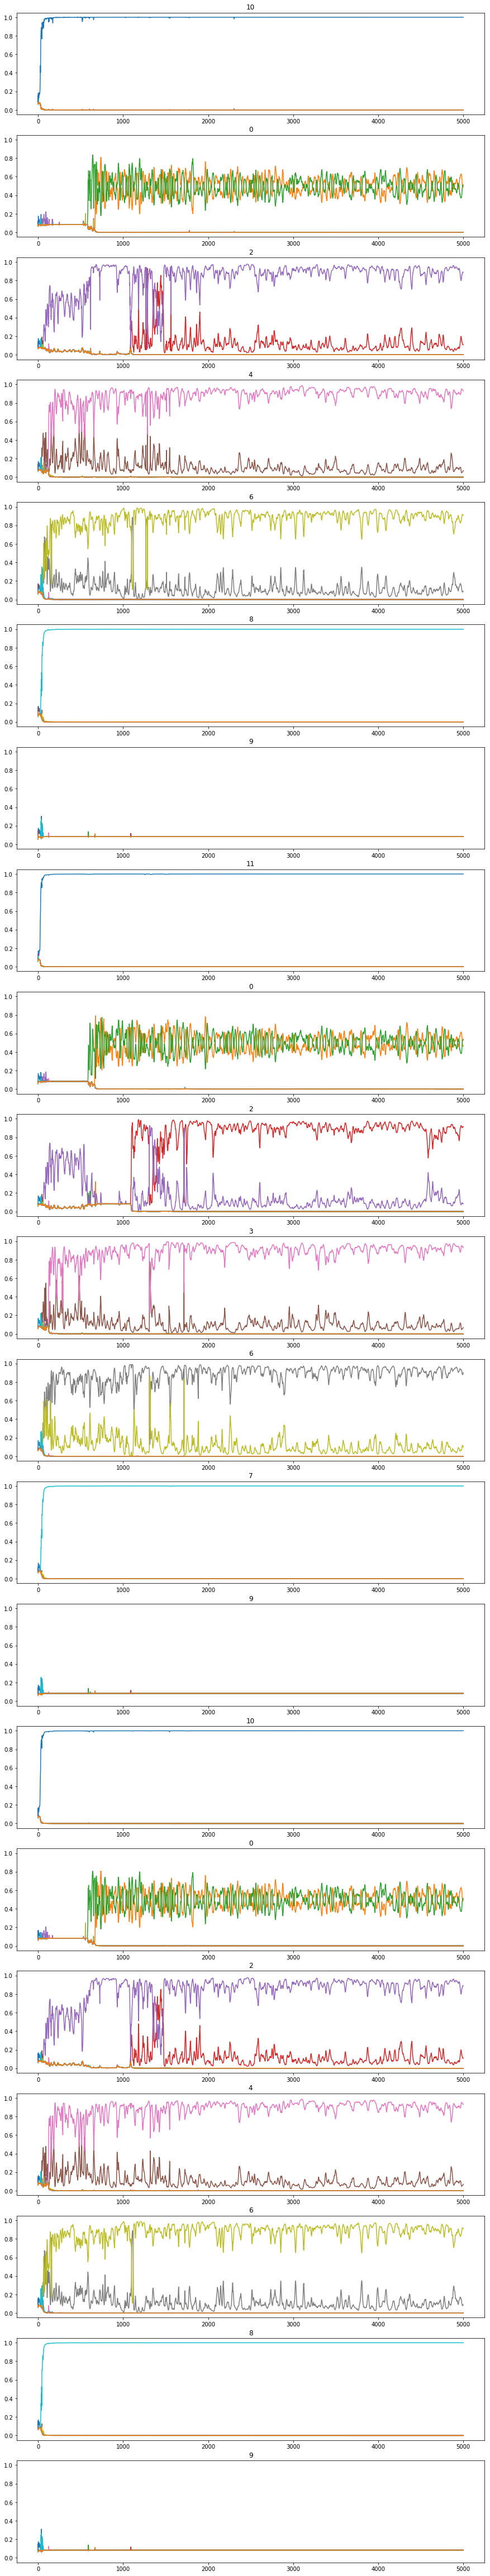

In [86]:
shiftpr = 15

d = 21
fig,axarr = plt.subplots(d,1,figsize=(15,4*d))

# mean over sub dim and squeeze batch dim
# M = trainD[shiftpr]['yhat'].mean((0,2))

subj = 0
M = trainD[shiftpr]['yhat'].squeeze()[subj]

for depth,ax in enumerate(axarr):
#   story = 0
#   transition = -3
#   depth = 7*story + transition
#   print(depth)
  frnode = evalseq[depth]
  ax.plot(M[:,depth,:])
  ax.set_ylim(-.05,1.05)
  ax.set_title(frnode)

In [ ]:
trained_nets = []

# eval data

## fgate analysis

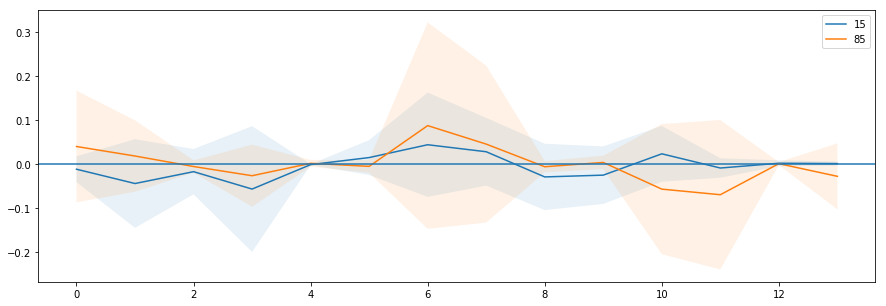

In [89]:
plt.figure(figsize=(15,5))
seq12L = [
  # last is A
  ['AAA','ABA'],['AAA','BBA'],
  ['BAA','ABA'],['BAA','BBA'],
  # last is B
  ['BBB','BAB'],['BBB','AAB'],
  ['ABB','BAB'],['AAA','AAB']]


for shiftpr,eval_data in evalD.items():

  # sum over batch and unit dims, mean over subj dim
  fgate_act = lambda seq: eval_data[seq]['fgate'].sum((1,3)).mean(0)
  fgate_act_diff = lambda seq1,seq2: fgate_act(seq1)-fgate_act(seq2)

  # average over different sequneces
  diff_arr = np.array([fgate_act_diff(seq1,seq2) for seq1,seq2 in seq12L])
  M = np.mean(diff_arr,0)[-14:]
  S = np.std(diff_arr,0)[-14:]

  plt.plot(M,label=shiftpr)
#   plt.plot(diff_arr.T[-14:],alpha=.1)
#   plt.scatter(range(len(M)),M)
  plt.fill_between(range(len(M)),M-S,M+S,alpha=.1)
  
plt.axhline(0)
plt.legend()

### nb: currently Xeval2 generates seqA=024689, seqB=023679. compare network state during input 6 which occurs in both sequences but preceds and follows different inputs in both cases. 

# Multistory backprop

In [17]:
lstm_size = 50 
nstories = 3
ML = MetaLearner(lstm_size,nstories)

shiftpr = 0
trainer = Trainer(ML,shift_pr=shiftpr,graph_pr=1)
eval_data = trainer.train_loop(5000)

initializing sub01
SGD01
0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0


In [18]:
yhat_data = eval_data['yhat']

##### evalpath = 1
- 10 0 2 4 6 8 9 
- 11 0 2 3 6 7 9
- 10 0 2 4 6 8 9

## network predictions

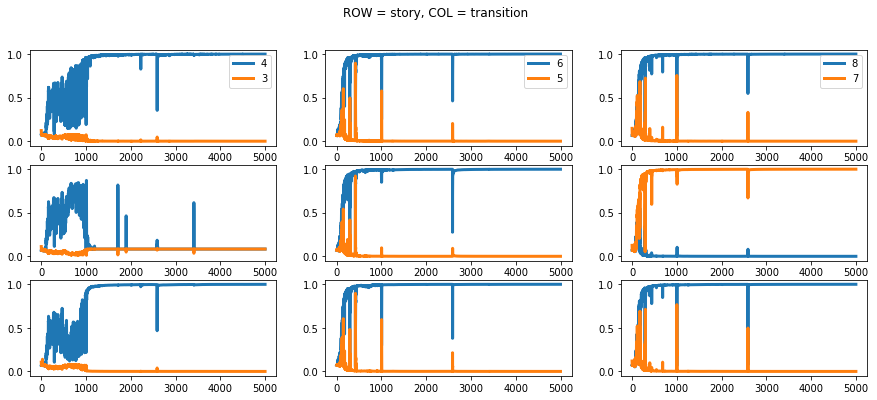

In [19]:
path = 1
tonodeD = {0:(0),1:(1,2),2:(4,3),3:(6,5),4:(8,7),5:(9),6:(10,11)}
fig,axarr= plt.subplots(3,3,figsize=(15,2*3)); 

for transition in [2,3,4]:
  xidx = transition-2
  for story in range(3):
    depth = story*7 + transition
    tonodes=tonodeD[transition]
    axarr[story,xidx].plot(yhat_data[:,path,depth,tonodes[0]],label=tonodes[0],lw=3)
    axarr[story,xidx].plot(yhat_data[:,path,depth,tonodes[1]],label=tonodes[1],lw=3)
    axarr[story,xidx].set_ylim(-.05,1.05)
  axarr[0,xidx].legend()

for ax in axarr.reshape(-1):
  ax.set_ylim(-.05,1.05)
ax = axarr[0,0]
plt.suptitle('ROW = story, COL = transition')
plt.savefig('figures/predictions/ABAstories-all_transitions-shiftpr_%i_1'%(shiftpr*100))

## fgate analysis

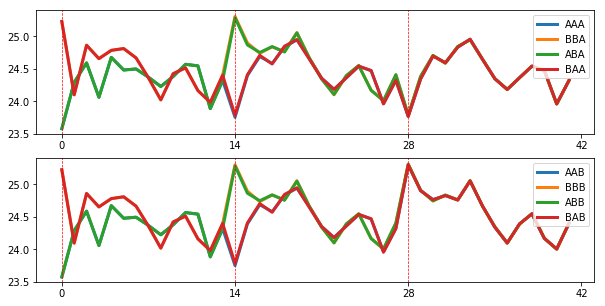

In [126]:
fig,axarr = plt.subplots(2,1,figsize=(10,5)); axarr=axarr.reshape(-1)

for seq in ['AAA','BBA','ABA','BAA']:
  Xeval,Yeval = CSWMLTask(1).get_Xeval2(seq)
  evalstep_data = trainer.eval_step(Xeval,Yeval)
  sum_fgate = np.sum(evalstep_data['fgate'][0],1)
  axarr[0].plot(sum_fgate,label=seq,lw=3)

for seq in ['AAB','BBB','ABB','BAB']:
  Xeval,Yeval = CSWMLTask(1).get_Xeval2(seq)
  evalstep_data = trainer.eval_step(Xeval,Yeval)
  sum_fgate = np.sum(evalstep_data['fgate'][0],1)
  axarr[1].plot(sum_fgate,label=seq,lw=3)


for ax in axarr:
  for t in range(0,42,14):
    ax.axvline(t,c='r',ls='--',lw=.7)
  ax.legend()
  ax.set_ylim(23.5,25.4)
  ax.set_xticks(np.arange(0,43,14))
  
# plt.savefig('figures/fgate not modulated by context')

In [154]:

fgate_dataD = {}

for seq in ['BBA','BAA','AAB','ABB','ABA','BAB']:
  Xeval,Yeval = CSWMLTask(1).get_Xeval2(seq)
  evalstep_data = trainer.eval_step(Xeval,Yeval)
  sum_fgate = np.sum(evalstep_data['fgate'][0],1)
  fgate_dataD[seq] = sum_fgate

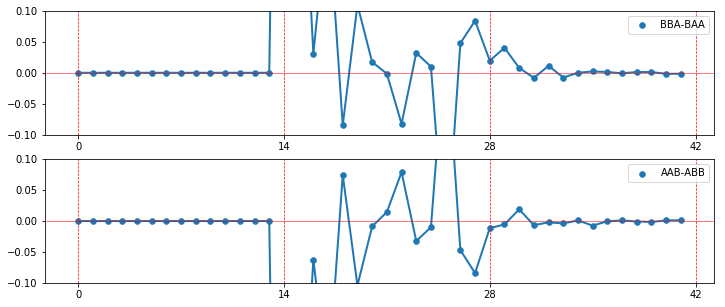

In [151]:
fig,axarr = plt.subplots(2,1,figsize=(12,5)); axarr=axarr.reshape(-1)


axarr[0].plot(fgate_dataD['BBA']-fgate_dataD['BAA'],lw=2)
axarr[0].scatter(range(42),fgate_dataD['BBA']-fgate_dataD['BAA'],lw=.5,label='BBA-BAA')
axarr[1].plot(fgate_dataD['AAB']-fgate_dataD['ABB'],lw=2)
axarr[1].scatter(range(42),fgate_dataD['AAB']-fgate_dataD['ABB'],lw=.5,label='AAB-ABB')

for ax in axarr:
  for t in range(0,43,14):
    ax.axvline(t,c='r',ls='--',lw=.7)
  ax.legend()
  ax.set_ylim(-.1,.1)
  ax.set_xticks(np.arange(0,43,14))
  ax.axhline(0,c='r',lw=.5)
plt.savefig('figures/context_effect_on_fgate')

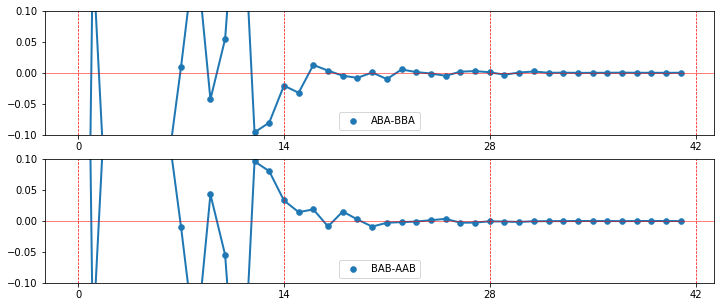

In [158]:
fig,axarr = plt.subplots(2,1,figsize=(12,5)); axarr=axarr.reshape(-1)

seq1,seq2='ABA','BBA'
axarr[0].plot(fgate_dataD[seq1]-fgate_dataD[seq2],lw=2)
axarr[0].scatter(range(42),fgate_dataD[seq1]-fgate_dataD[seq2],lw=.5,label='%s-%s'%(seq1,seq2))
seq1,seq2='BAB','AAB'
axarr[1].plot(fgate_dataD[seq1]-fgate_dataD[seq2],lw=2)
axarr[1].scatter(range(42),fgate_dataD[seq1]-fgate_dataD[seq2],lw=.5,label='%s-%s'%(seq1,seq2))

for ax in axarr:
  for t in range(0,43,14):
    ax.axvline(t,c='r',ls='--',lw=.7)
  ax.legend()
  ax.set_ylim(-.1,.1)
  ax.set_xticks(np.arange(0,43,14))
  ax.axhline(0,c='r',lw=.5)
plt.savefig('figures/2stepcontext_effect_on_fgate')

## multiple networks fgate analysis

In [8]:
### TRAIN AND SAVE NETWORKS
# lstm_size = 50
# nstories = 3
# nepochs = 5000
# graphpr = 1
# shiftpr = 0.2

# nnets = 3
# ML = MetaLearner(lstm_size,nstories)
# for netn in range(nnets):
#   ML.reinitialize()
#   trainer = Trainer(ML,shift_pr=shiftpr,graph_pr=graphpr)
#   train_data = trainer.train_loop(nepochs)
#   for seq in ['AAA','ABA','BAA','BBA']:
#     Xeval,Yeval = CSWMLTask(1).get_Xeval2(seq)
#     evalstep_data = trainer.eval_step(Xeval,Yeval)
#     fpath = 'eval_data/S%i-shift_%i-seq_%s'%(netn,100*shiftpr,seq)
#     np.save(fpath,evalstep_data)

initializing sub01
SGD01
**reinitializing weights** - incremental seeds
reinitializing sub02
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
**reinitializing weights** - incremental seeds
reinitializing sub03
0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


In [20]:
L = []
fpathL = glob('eval_data/local_sweep/*')
D={20:{},80:{},50:{}}
print(fpathL[0])
for fpath in fpathL:
  netn = int(fpath.split('/')[-1].split('-')[0][1])
  prshift = int(fpath.split('/')[-1].split('-')[1].split('_')[1])
  seq = fpath.split('_')[-1].split(".")[0]
  print(netn,prshift,seq,'\n',fpath)
  if seq not in D[prshift]: D[prshift][seq] = []
  eval_data = np.load(fpath)
  fgate_data = np.sum(eval_data['fgate'].squeeze(),1)
  D[prshift][seq].append(fgate_data)

eval_data/local_sweep/S7-shift_80-seq_BBA.npy
7 80 BBA 
 eval_data/local_sweep/S7-shift_80-seq_BBA.npy
9 80 ABA 
 eval_data/local_sweep/S9-shift_80-seq_ABA.npy
1 80 BAA 
 eval_data/local_sweep/S1-shift_80-seq_BAA.npy
4 80 BAA 
 eval_data/local_sweep/S4-shift_80-seq_BAA.npy
2 80 BBA 
 eval_data/local_sweep/S2-shift_80-seq_BBA.npy
5 80 AAA 
 eval_data/local_sweep/S5-shift_80-seq_AAA.npy
3 80 ABA 
 eval_data/local_sweep/S3-shift_80-seq_ABA.npy
8 80 BBA 
 eval_data/local_sweep/S8-shift_80-seq_BBA.npy
6 80 ABA 
 eval_data/local_sweep/S6-shift_80-seq_ABA.npy
0 80 AAA 
 eval_data/local_sweep/S0-shift_80-seq_AAA.npy
5 20 BAA 
 eval_data/local_sweep/S5-shift_20-seq_BAA.npy
3 50 BBA 
 eval_data/local_sweep/S3-shift_50-seq_BBA.npy
3 20 BBA 
 eval_data/local_sweep/S3-shift_20-seq_BBA.npy
8 20 ABA 
 eval_data/local_sweep/S8-shift_20-seq_ABA.npy
6 20 BBA 
 eval_data/local_sweep/S6-shift_20-seq_BBA.npy
0 50 BAA 
 eval_data/local_sweep/S0-shift_50-seq_BAA.npy
0 20 BAA 
 eval_data/local_sweep/S0-shift_

In [94]:
nnets = 10
seqL = ['AAA','ABA','BBA','BAA']
D = {20:{seq:np.empty([nnets,42,50]) for seq in seqL},
     50:{seq:np.empty([nnets,42,50]) for seq in seqL},
     80:{seq:np.empty([nnets,42,50]) for seq in seqL}
    }
for shiftpr in [20,80]:
  for seq in seqL:
    for netn in range(nnets):
      fpath = 'eval_data/local_sweep/S%i-shift_%i-seq_%s.npy'%(netn,shiftpr,seq)
      eval_data = np.load(fpath)
      fgate_data = eval_data['fgate'].squeeze()
      D[shiftpr][seq][netn] = fgate_data
      

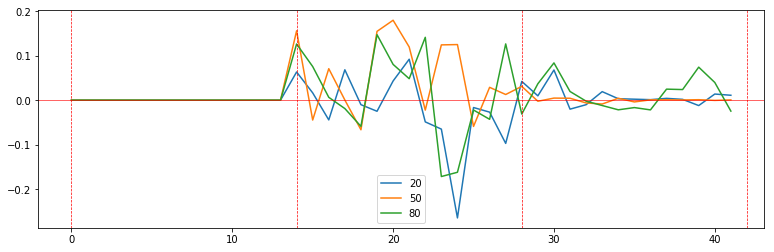

In [72]:
plt.figure(figsize=(13,4))

ax = plt.gca()
seq1,seq2 = 'AAA','ABA'
for shiftpr in [20,50,80]:
  diff = np.mean(D[shiftpr][seq1].sum(2) - D[shiftpr][seq2].sum(2),0)
  ax.plot(diff,label=shiftpr)

plt.legend()

ax.axhline(0,c='r',lw=.6)
for t in range(0,43,14):
  ax.axvline(t,c='r',ls='--',lw=.7)

No handles with labels found to put in legend.


(42,)
(42,)
(42,)


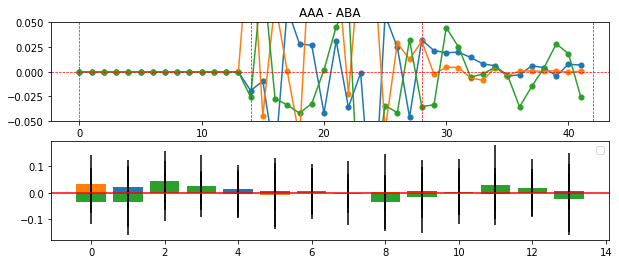

In [7]:
fig,axarr = plt.subplots(2,1,figsize=(10,4));axarr=axarr.reshape(-1)
ax = plt.gca()

seq1,seq2 = 'AAA','ABA'
for shiftpr in [20,50,80]:
  axarr[0].set_title('%s - %s'%(seq1,seq2))
  diff = np.mean(D[shiftpr][seq1],0) - np.mean(D[shiftpr][seq2],0)
  axarr[0].plot(diff,label = '%i'%(shiftpr))
  axarr[0].scatter(range(42),diff,lw=.1)
  std_err = np.std(D[shiftpr][seq1],0)/np.sqrt(len(D[shiftpr][seq1]))
  print(std_err.shape)
  axarr[1].bar(range(14),diff[-14:],yerr=std_err[-14:])

axarr[1].axhline(0,c='r')
ax = axarr[0]
for t in range(0,43,14):
  ax.axvline(t,c='r',ls='--',lw=.7)
ax.axhline(0,c='r',ls='--',lw=.7)
axarr[0].set_ylim(-.05,.05)
plt.legend()

### the above analysis should be done on multiple networks to get group averages of the effect of context on  fgate activation.

# single subject t-by-t fgate RSA

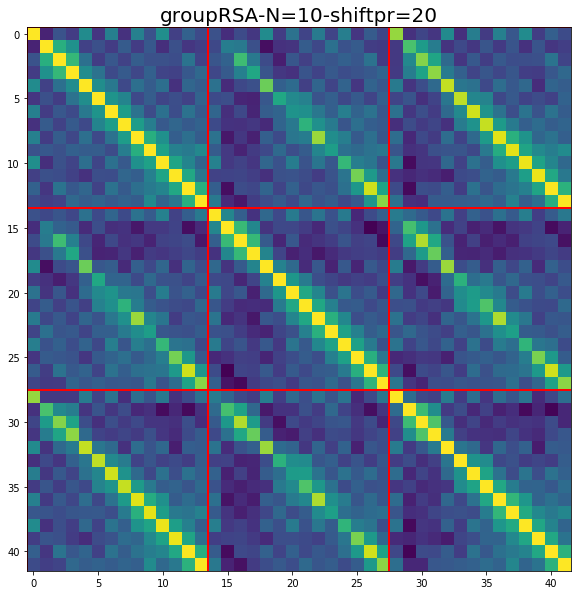

In [101]:
nnets = 10
shiftpr = 20
plt.figure(figsize=(10,10))
ax = plt.gca()
group_RSA = np.zeros([42,42])
for netn in range(nnets):
  group_RSA += np.corrcoef(D[shiftpr][seq2][netn])/nnets
ax.imshow(group_RSA)
for t in range(0,42,14):
  ax.axvline(t-.5,c='r',ls='-',lw=2)
  ax.axhline(t-.5,c='r',ls='-',lw=2)
title = 'groupRSA-N=%i-shiftpr=%i'%(nnets,shiftpr)
ax.set_title(title,fontsize=20)
plt.savefig('figures/fgate/'+title)

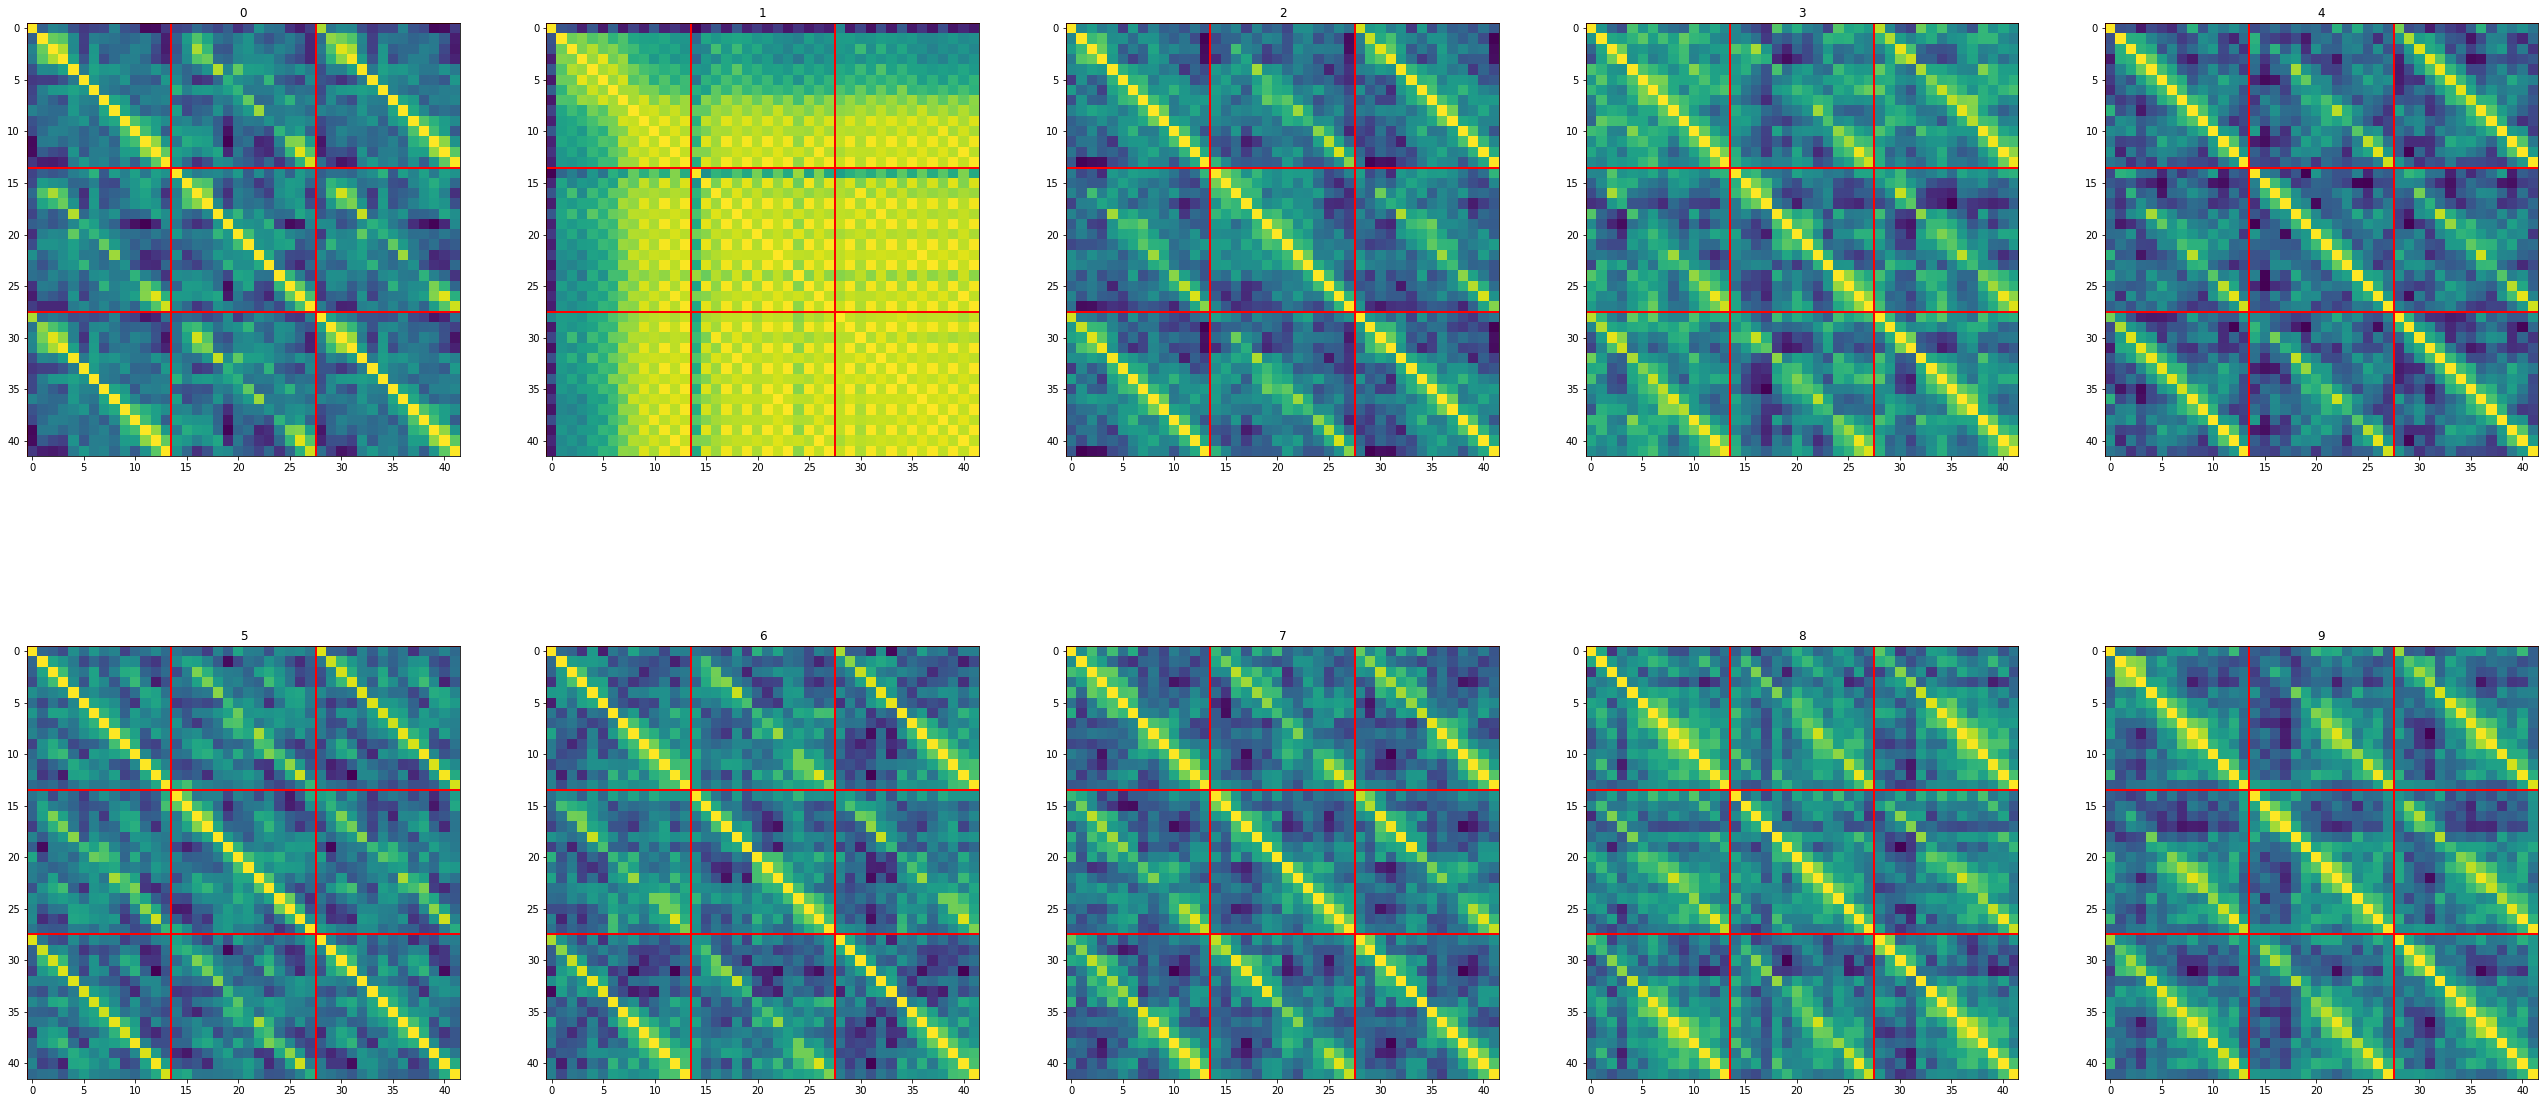

In [118]:
nnets = 10
shiftpr = 80
f = 3
fig,axarr = plt.subplots(2,5,figsize=(f*15,f*7));

for netn,ax in enumerate(axarr.reshape(-1)):
  subj_RSA = np.corrcoef(D[shiftpr][seq2][netn])/nnets
  ax.imshow(subj_RSA)
  ax.set_title(netn)
  for t in range(0,42,14):
    ax.axvline(t-.5,c='r',ls='-',lw=2)
    ax.axhline(t-.5,c='r',ls='-',lw=2)
  
title = 'subjRSAs-N=%i-shiftpr=%i'%(nnets,shiftpr)
# ax.set_title(title,fontsize=20)
plt.savefig('figures/fgate/'+title)